# Isochrones - Nico Keeghan

In this notebook I will fit Girardi isochrones to a colour-magnitude plot of NGC 3293. This will allow me to determine an age of NGC 3293. The offset of the isochrone will allow me to determine the distance to NGC 3293 via the distance modulus.

We will start by importing the necessary libraries.

In [1]:
import numpy as np
import astropy
from astropy import units as u
import matplotlib.pyplot as plt 

We start by reading in the magnitudes that we have calculated.

In [2]:
from astropy.table import QTable

mags = QTable.read("obj_magnitudes.ecsv", format='ascii.ecsv')

We will plot the V-band magnitude as a function of the B-V colour for NGC 3293. This is essentially a HR-diagram.

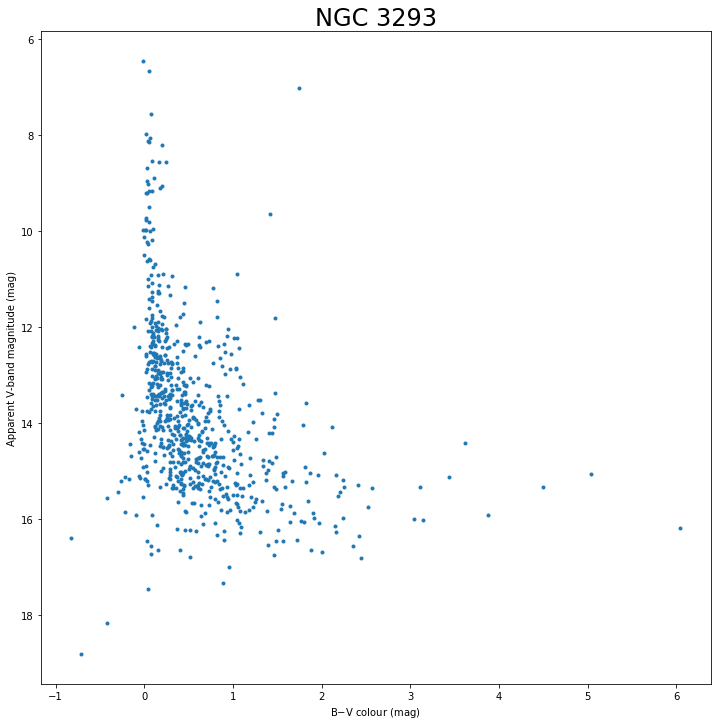

In [3]:
px = mags['Bmag'] - mags['Vmag']   # plot B-V colour on x-axis
py = mags['Vmag']               # plot V-band magnitude on y-axis

fig, ax = plt.subplots(figsize = (12,12))

plt.rcParams.update({'font.size': 20})
plt.plot(px, py, '.')
plt.xlabel('B$-$V colour (mag)')
plt.ylabel('Apparent V-band magnitude (mag)')
plt.title('NGC 3293')

# invert y-axis so brighter stars are at the top
ax.invert_yaxis()

plt.show()

Reassuringly, this diagram looks very similar to Figure 9 in Preibisch et al (2017) (DOI:10.1051/0004-6361/201730874).

According to Preibisch et al (2017) (DOI:10.1051/0004-6361/201730874), the V-band dust extinction of NGC 3293 varies, with lower extinction near the cluster centre and greater extinction for stars further from the centre due to interstellar clouds. They suggest that for the central region of the cluster, $A_v \approx 1$ mag. Using a standard Galactic reddening law of $A_V = 3.1 E(B − V )$ as in Dufton et al (2006) (10.1051/0004-6361:20065392), we have $E(B-V) =\approx 1/3.1$ for NGC 3293.

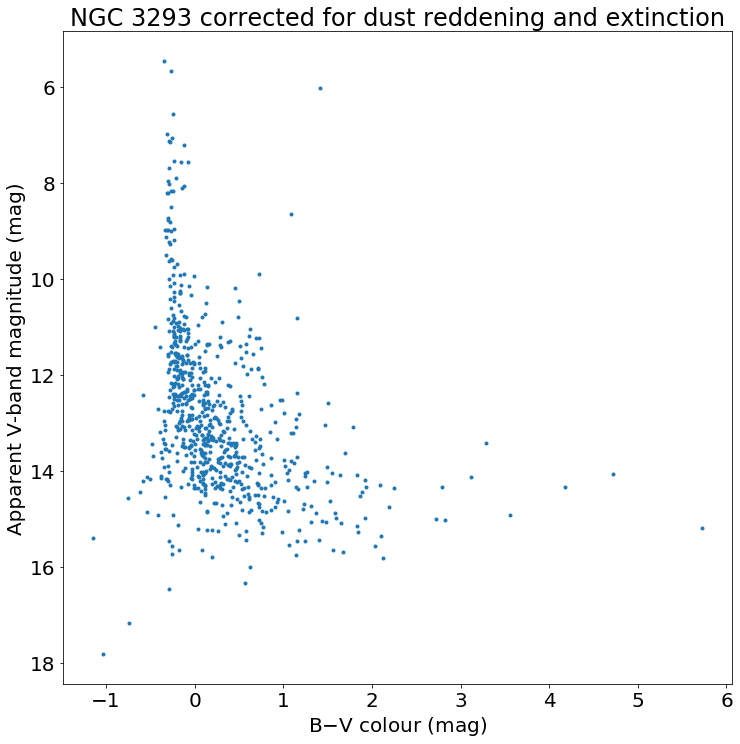

In [4]:
extinction = 1
reddening = extinction/3.1

px = mags['Bmag'] - mags['Vmag'] - reddening   # plot B-V colour on x-axis
py = mags['Vmag'] - extinction                 # plot V-band magnitude on y-axis

fig, ax = plt.subplots(figsize = (12,12))

plt.rcParams.update({'font.size': 20})
plt.plot(px, py, '.')
plt.xlabel('B$-$V colour (mag)')
plt.ylabel('Apparent V-band magnitude (mag)')
plt.title('NGC 3293 corrected for dust reddening and extinction')

# invert y-axis so brighter stars are at the top
ax.invert_yaxis()

plt.show()

We will now match isochrones to this plot of NGC 3293 to determine its age. I generated Girardi isochrones for a range of ages from 10 Myr to 100 Myr, using http://stev.oapd.inaf.it/cgi-bin/cmd_3.6.

In [5]:
# Code adapted from Girardi_UBVRI.ipynb on Moodle

class isochroneclass:
    def __init__(self):
            self.filename = "NULL                            "      # Relevant filename
            self.age = -99.0                                        # Age (log)
            self.m = []                                   # Star masses
            self.U = []                                   # Star U-band magnitudes
            self.B = []                                   # Star B-band magnitudes
            self.V = []                                   # Star V-band magnitudes
            self.R = []                                   # Star R-band magnitudes
            self.I = []                                   # Star I-band magnitudes

Read in the generated isochrones.

In [6]:
# Adapted from Girardi_UBVRI.ipynb on Moodle

fname = 'isochrones/output545039620091_1e7_1e8.dat'
isochrones = {}


f=open(fname,"r")
lines=f.readlines()

curr_age = -99.0

# iterate through lines of data file and add relevant information to ic object
for x in lines:
    if x[0]!='#':
        split_line = x.split()
        age = float(split_line[2])
        if age != curr_age:
            if curr_age > -99.0:
                isochrones[curr_age] = ic
            ic=isochroneclass()               # create new ic class
            curr_age = age                    # update current age
            ic.age = curr_age                 # set age for new isochrone
        ic.m.append(float(split_line[5]))     # mass of star
        ic.U.append(float(split_line[28]))    # U-band magnitude
        ic.B.append(float(split_line[29]))    # B-band magnitude
        ic.V.append(float(split_line[30]))    # V-band magnitude
        ic.R.append(float(split_line[31]))    # R-band magnitude
        ic.I.append(float(split_line[32]))    # I-band magnitude
        
isochrones[curr_age] = ic

f.close()


print('Ages:')
for key in isochrones:
    print('%.2e' % 10**isochrones[key].age)

print("")
print('Check that the first line of', fname, 'agrees with these values')
print(isochrones[7.0].m[0])
print(isochrones[7.0].U[0])
print(isochrones[7.0].B[0])
print(isochrones[7.0].V[0])
print(isochrones[7.0].R[0])
print(isochrones[7.0].I[0])



Ages:
1.00e+07
2.00e+07
3.00e+07
4.00e+07
5.00e+07
6.00e+07
7.00e+07
8.00e+07
9.00e+07
1.00e+08

Check that the first line of isochrones/output545039620091_1e7_1e8.dat agrees with these values
0.09
17.204
15.776
14.3
12.452
10.358


We can see that we have read in all of the ages, and that the first line matches so it looks like everything has been read in correctly.

Now that we have read these in, we need to plot the isochrones. We will use an offset to adjust for distance by lining up the main sequence of the isochrones to the main sequence of NGC 3293. By eye, an offset of 12 mag seems to line the main sequence of the isochrones up with the main sequence of NGC 3293 quite well. I can fine-tune this a bit more if necessary once a find a suitable age.

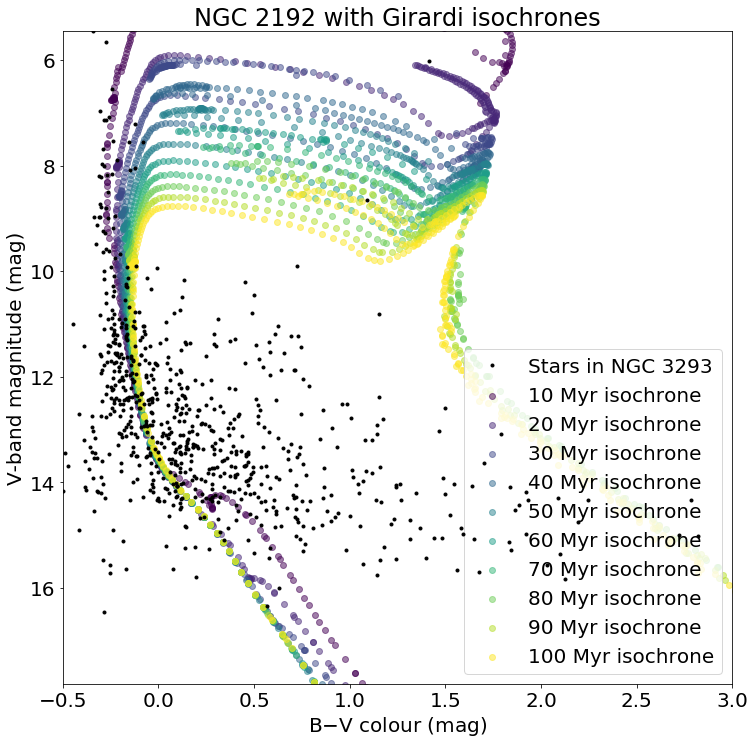

In [7]:
offset = 12

# get some sequential colors to plot with to easily see the differences due to age
from matplotlib import cm
colors = cm.viridis(np.linspace(0,1,len(isochrones.keys())))

fig, ax = plt.subplots(figsize = (12,12))

plt.rcParams.update({'font.size': 20})
plt.plot(px, py, '.', color='black',label='Stars in NGC 3293',zorder=10)

for age,color in zip(isochrones.keys(),colors):
    BV=np.array(isochrones[age].B)-np.array(isochrones[age].V)
    offsetV = np.array(isochrones[age].V) + offset

    plt.scatter(BV, offsetV, color=color, label='{:.0f} Myr isochrone'.format(10**(isochrones[age].age-6)),alpha=0.5)

plt.xlabel('B$-$V colour (mag)')
plt.ylabel('V-band magnitude (mag)')
plt.title('NGC 2192 with Girardi isochrones')

# set y-axis limits so we can see the stars
plt.ylim(min(py),max(py))
plt.xlim(-0.5,3)

# invert y-axis so brighter stars are at the top
ax.invert_yaxis()

plt.legend(loc='lower right')

plt.show()

From this plot we can see that the main sequence of NGC 3293 extends into bright (low-valued) V-band magnitudes, suggesting that the isochrones for ages of 30 Myr and greater are not good fits to the data.

As such, we will focus on the isochrones with ages of 20 Myr or less. We generate

In [8]:
# Adapted from Girardi_UBVRI.ipynb on Moodle

fname = 'isochrones/output410618231006_1e6_to_15e6.dat'


f=open(fname,"r")
lines=f.readlines()

curr_age = -99.0

# iterate through lines of data file and add relevant information to ic object
for x in lines:
    if x[0]!='#':
        split_line = x.split()
        age = float(split_line[2])
        if age != curr_age:
            if curr_age > -99.0:
                isochrones[curr_age] = ic
            ic=isochroneclass()               # create new ic class
            curr_age = age                    # update current age
            ic.age = curr_age                 # set age for new isochrone
        ic.m.append(float(split_line[5]))     # mass of star
        ic.U.append(float(split_line[28]))    # U-band magnitude
        ic.B.append(float(split_line[29]))    # B-band magnitude
        ic.V.append(float(split_line[30]))    # V-band magnitude
        ic.R.append(float(split_line[31]))    # R-band magnitude
        ic.I.append(float(split_line[32]))    # I-band magnitude
        
isochrones[curr_age] = ic

f.close()


print('Ages:')
for key in isochrones:
    print('%.2e' % 10**isochrones[key].age)

print("")
print('Check that the first line of', fname, 'agrees with these values')
print(isochrones[6.0].m[0])
print(isochrones[6.0].U[0])
print(isochrones[6.0].B[0])
print(isochrones[6.0].V[0])
print(isochrones[6.0].R[0])
print(isochrones[6.0].I[0])



Ages:
1.00e+07
2.00e+07
3.00e+07
4.00e+07
5.00e+07
6.00e+07
7.00e+07
8.00e+07
9.00e+07
1.00e+08
1.00e+06
3.00e+06
5.00e+06
7.00e+06
9.00e+06
1.10e+07
1.30e+07
1.50e+07

Check that the first line of isochrones/output410618231006_1e6_to_15e6.dat agrees with these values
0.09
14.086
13.075
11.729
10.124
8.225


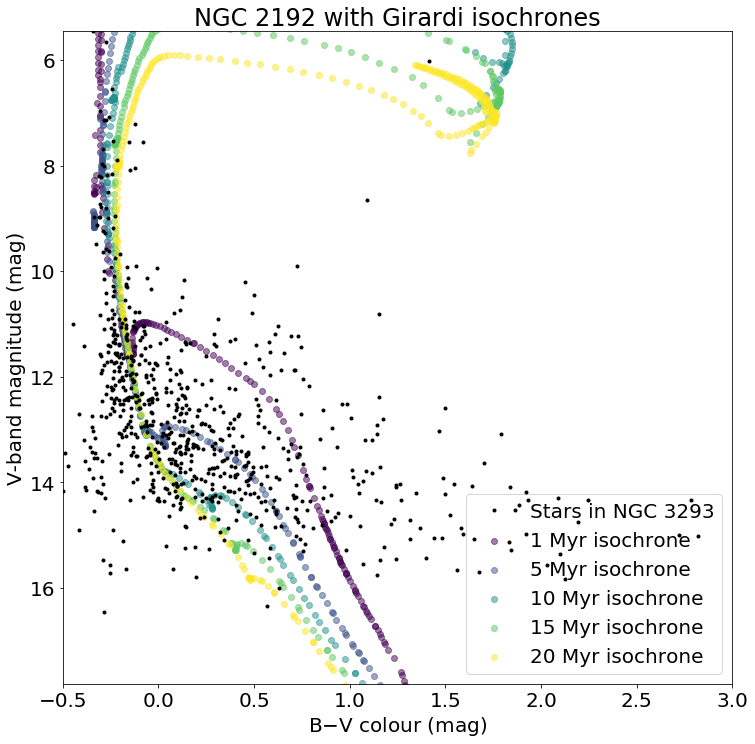

In [11]:
offset = 12

# isochrones of log(age) that we are interested in, corresponding to age = 1, 5, 10, 15, 20 Myr.
ages = [6.0,6.69897,7.0,7.17609,7.30103]

# get some sequential colors to plot with to easily see the differences due to age
colors = cm.viridis(np.linspace(0,1,len(ages)))

fig, ax = plt.subplots(figsize = (12,12))

plt.rcParams.update({'font.size': 20})
plt.plot(px, py, '.', color='black',label='Stars in NGC 3293',zorder=10)

for age,color in zip(ages,colors):
    BV=np.array(isochrones[age].B)-np.array(isochrones[age].V)
    offsetV = np.array(isochrones[age].V) + offset

    plt.scatter(BV, offsetV, color=color, label='{:.0f} Myr isochrone'.format(10**(isochrones[age].age-6)),alpha=0.5)

plt.xlabel('B$-$V colour (mag)')
plt.ylabel('V-band magnitude (mag)')
plt.title('NGC 2192 with Girardi isochrones')

# set y-axis limits so we can see the stars
plt.ylim(min(py),max(py))
plt.xlim(-0.5,3)

# invert y-axis so brighter stars are at the top
ax.invert_yaxis()

plt.legend(loc='lower right')

plt.show()

The 1 Myr isochrone has a distinct dip at $B-V \approx 0$ mag, followe by an upward arc as $B-V$ color increases. This does not match the stars in NGC 3293. Further, even when the offset is varied, the 20 Myr isochrone has a slope that is too steep to match with the main sequence of NGC 3293. Rather, the distribution of stars in NGC 3293 seems to follow more closely to the 5, 10, and 15 Myr isochrones.

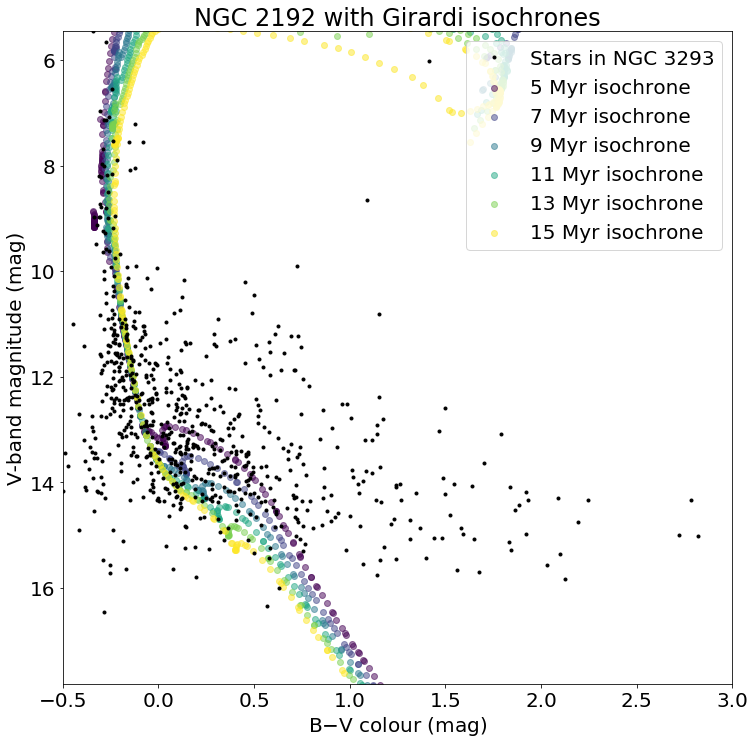

In [27]:
offset = 12

# isochrones of log(age) that we are interested in, corresponding to ages between 5 and 15 Myr.
ages = [6.69897, 6.8451, 6.95424, 7.04139, 7.11394, 7.17609]

# get some sequential colors to plot with to easily see the differences due to age
colors = cm.viridis(np.linspace(0,1,len(ages)))

fig, ax = plt.subplots(figsize = (12,12))

plt.rcParams.update({'font.size': 20})
plt.plot(px, py, '.', color='black',label='Stars in NGC 3293',zorder=10)

for age,color in zip(ages,colors):
    BV=np.array(isochrones[age].B)-np.array(isochrones[age].V)
    offsetV = np.array(isochrones[age].V) + offset

    plt.scatter(BV, offsetV, color=color, label='{:.0f} Myr isochrone'.format(10**(isochrones[age].age-6)),alpha=0.5)

plt.xlabel('B$-$V colour (mag)')
plt.ylabel('V-band magnitude (mag)')
plt.title('NGC 2192 with Girardi isochrones')

# set y-axis limits so we can see the stars
plt.ylim(min(py),max(py))
plt.xlim(-0.5,3)

# invert y-axis so brighter stars are at the top
ax.invert_yaxis()

plt.legend(loc='upper right')

plt.show()